<a href="https://colab.research.google.com/github/akh-04/ADS_Causal_ML/blob/main/Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Causal Inference: What Is It?
*Akhilesh Dongre*


Causal inference seeks to address questions of causation. The use of causal inference has numerous applications. Any of the following questions can be answered using causal inference.

Did individuals who received the therapy actually benefit from it?
Was it the marketing initiative or the holiday that stimulated more sales this month?
How much of an impact would higher salaries have on output?
Essentially it is the study of the treatments and it’s outcomes.

##Demonstration of confounding in causal inference
Suppose we are interested in investigating the effect of a binary treatment variable (T) on an outcome variable (Y), and we suspect that a continuous covariate (X) may be a confounder of this relationship. We can use the following code to simulate a dataset with these variables:

In [1]:
import numpy as np
import pandas as pd

np.random.seed(1234)

# Simulate data
n = 10
X = np.random.normal(loc=0, scale=1, size=n)
T = np.random.binomial(n=1, p=0.5, size=n)
Y = 2*T + 0.5*X + np.random.normal(loc=0, scale=1, size=n)

# Create dataframe
df = pd.DataFrame({'X': X, 'T': T, 'Y': Y})

In this code, we first set the random seed to ensure that the results are reproducible. We then simulate 1000 values of the continuous covariate (X) from a normal distribution with mean 0 and standard deviation 1, a binary treatment variable (T) with a probability of success of 0.5, and an outcome variable (Y) with a linear relationship to T and X, as well as random error from a normal distribution with mean 0 and standard deviation 1. Finally, we create a pandas dataframe with the simulated data.

To investigate the potential confounding effect of X, we can first calculate the unadjusted treatment effect as the difference in means between the treatment and control groups:

In [2]:
# Unadjusted treatment effect
te_unadj = df.loc[df['T'] == 1, 'Y'].mean() - df.loc[df['T'] == 0, 'Y'].mean()

print('Unadjusted treatment effect: ', round(te_unadj, 2))

Unadjusted treatment effect:  1.63


This code subsets the dataframe by treatment group and calculates the mean outcome variable for each group, then subtracts the mean for the control group from the mean for the treatment group to obtain the unadjusted treatment effect.

Next, we can adjust for the potential confounding effect of X by fitting a linear regression model with T and X as predictor variables:

In [3]:
# Adjusted treatment effect
import statsmodels.api as sm

model = sm.OLS.from_formula('Y ~ T + X', data=df)
results = model.fit()

te_adj = results.params['T']

print('Adjusted treatment effect: ', round(te_adj, 2))

Adjusted treatment effect:  2.22


We fit a linear regression model with Y as the response variable, and T and X as predictor variables. We then extract the coefficient for T from the model results to obtain the adjusted treatment effect.

Comparing the unadjusted and adjusted treatment effects allows us to see the potential impact of confounding in this relationship. If the adjusted treatment effect is substantially different from the unadjusted treatment effect, this suggests that the covariate X is a confounder and needs to be accounted for in the causal inference.

##Demonstration of Stratification in causal inference



Suppose we are interested in investigating the effect of a binary treatment variable (T) on an outcome variable (Y), and we suspect that a categorical covariate (Z) may be a confounder of this relationship. We can use the following code to simulate a dataset with these variables:

The Causal Relationship we are exploring between Z,T and Y


```
Z --> T --> Y
  \      /
   \    /
    Confounder: Z
```



In [4]:
from graphviz import Digraph
dag = Digraph()
dag.node('Z', 'Z')
dag.node('T', 'T')
dag.node('Y', 'Y')


dag.edges(['ZT', 'TY', 'ZY', 'YZ'])




In [5]:
np.random.seed(283)

# Simulate data
n = 120
Z = np.random.choice(['A', 'B', 'C'], size=n)
T = np.random.binomial(n=1, p=0.5, size=n)
Y = 2*T + 0.5*(Z == 'B') + np.random.normal(loc=0, scale=1, size=n)

# Create dataframe
df = pd.DataFrame({'Z': Z, 'T': T, 'Y': Y})


Now, we first set the random seed to ensure that the results are reproducible. We then simulate 1000 values of the categorical covariate (Z) by randomly sampling from the set ['A', 'B', 'C'], a binary treatment variable (T) with a probability of success of 0.5, and an outcome variable (Y) with a linear relationship to T and a binary indicator variable for Z == 'B', as well as random error from a normal distribution with mean 0 and standard deviation 1. Finally, we create a pandas dataframe with the simulated data.

To investigate the potential confounding effect of Z, we can first calculate the unadjusted treatment effect separately for each level of Z:

In [6]:
# Unadjusted treatment effect by strata
strata = df.groupby('Z')

te_unadj = strata.apply(lambda x: x.loc[x['T'] == 1, 'Y'].mean() - x.loc[x['T'] == 0, 'Y'].mean())

print('Unadjusted treatment effect by strata: \n', te_unadj)

Unadjusted treatment effect by strata: 
 Z
A    1.584659
B    1.800243
C    1.946186
dtype: float64


This code groups the dataframe by the categorical covariate Z and applies a function to each group to calculate the unadjusted treatment effect separately for each stratum.

Next, we can adjust for the potential confounding effect of Z by stratifying the data by Z and fitting a linear regression model with T as a predictor variable in each stratum:

In [7]:
# Adjusted treatment effect by strata
te_adj = []

for z in ['A', 'B', 'C']:
    model = sm.OLS.from_formula('Y ~ T', data=df.loc[df['Z'] == z])
    results = model.fit()
    te_adj.append(results.params['T'])

te_adj = pd.Series(te_adj, index=['A', 'B', 'C'])

print('Adjusted treatment effect by strata: \n', te_adj)

Adjusted treatment effect by strata: 
 A    1.584659
B    1.800243
C    1.946186
dtype: float64


This code uses a for loop to iterate over each level of the categorical covariate Z and fit a linear regression model with Y as the response variable and T as the predictor variable in each stratum. We then extract the coefficient for T from each model to obtain the adjusted treatment effect in each stratum.

Comparing the unadjusted and adjusted treatment effects within each stratum allows us to see the potential impact of confounding in each subgroup. If the adjusted treatment effect is substantially different from the unadjusted treatment effect within a particular stratum, this suggests that the covariate Z is a confounder and needs to be accounted for in the causal inference.

Unadjusted values refer to the raw or observed association between the treatment and the outcome, without accounting for any potential confounding variables that may be affecting the relationship between the two. In other words, unadjusted values represent the "naive" effect of the treatment on the outcome.

Adjusted values, on the other hand, refer to the effect of the treatment on the outcome after accounting for potential confounding variables. Adjusted values are obtained by using statistical methods, such as regression modeling, to adjust for the effects of confounding variables that may be associated with both the treatment and the outcome.

## A sample example for finding causal inferences

The dataset consists of web analytics data trying to capture the user click rate. The dataset consists of tagname, visisblity of the tag, num clicks and the different versions.

In [8]:
data_url = "https://raw.githubusercontent.com/akh-04/AED_1/f0f3b60ea3194156419a75328abc40a3a438a0f0/data.csv"

In [9]:
ab_testing_data = pd.read_csv(data_url)

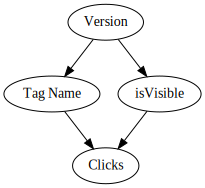

In [10]:
from graphviz import Digraph
dag = Digraph()
dag.node('T', 'Tag Name')
dag.node('S', 'isVisible')
dag.node('V', 'Version')
dag.node('C', 'Clicks')

dag.edges(['VT', 'VS', 'SC', 'TC'])
dag

We will find the causation on the basis of the DAG above

In [11]:
!pip install torch==1.7.0
!pip install pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.7.0 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.7.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import torch
V_prob = torch.tensor([0.23, 0.194, 0.207, 0.190, 0.177])
S_prob = torch.tensor([[0.16, 0.84], [0.19, 0.81], [0.22, 0.78], [0.08, 0.92], [0.11, 0.89]])

T_prob = torch.tensor([[0.404, 0.014, 0.014, 0.0001, 0.289, 0.0001, 0.01, 0.029, 0.014, 0.043, 0.0001, 0.043, 0.115, 0.0001, 0.01], 
                       [0.446, 0.017, 0.017, 0.0002, 0.240, 0.0002, 0.017, 0.034, 0.017, 0.0002, 0.0002, 0.103, 0.086, 0.0002, 0.0174], \
                       [0.4503, 0.016, 0.016, 0.032, 0.209, 0.0002, 0.016, 0.032, 0.016, 0.0002, 0.016, 0.080, 0.080, 0.016, 0.016], \
                       [0.489, 0.017, 0.017, 0.0002, 0.244, 0.0002, 0.0177, 0.052, 0.0177, 0.0177, 0.0002, 0.070, 0.035, 0.0002, 0.0177], \
                       [0.507, 0.019, 0.019, 0.019, 0.169, 0.019, 0.019, 0.037, 0.019, 0.0002, 0.0002, 0.0754, 0.0754, 0.0002, 0.019]])

C_prob = torch.tensor([[[0.0009, 0.996, 0.009, 0.009, 0.009], [0.03, 0.57, 0.007, 0.05, 0.33]],
                       [[0.20, 0.001, 0.001, 0.20, 0.59], [0.20, 0.20, 0.20, 0.20, 0.20]], \
                       [[0.20, 0.20, 0.20, 0.20, 0.20], [0.001, 0.001, 0.001, 0.20, 0.797]], \
                       [[0.002, 0.9912, 0.002, 0.002, 0.002], [0.2, 0.2, 0.2, 0.2, 0.2]], \
                       [[0.0003, 0.998, 0.0003, 0.0003, 0.0003], [0.0001, 0.9602, 0.0001, 0.0001, 0.03932]], \
                       [[0.0064, 0.9741, 0.0064, 0.0064, 0.0064], [0.2, 0.2, 0.2, 0.2, 0.2]], \
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.001, 0.796, 0.001, 0.001, 0.20]], \
                       [[0.002, 0.992, 0.002, 0.002, 0.002], [0.0009, 0.9962, 0.0009, 0.0009, 0.0009]], \
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.0013, 0.796, 0.00132, 0.00132]],\
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.001, 0.993, 0.002, 0.002, 0.002]],\
                       [[0.0064, 0.974, 0.006, 0.006, 0.006],[0.2, 0.2, 0.2, 0.2, 0.2]],\
                       [[0.0011, 0.996, 0.001, 0.001, 0.001],[0.0004, 0.936, 0.0004, 0.0004, 0.0628]],\
                       [[0.2,0.2,0.2, 0.2, 0.2],[0.0003, 0.9157, 0.0003, 0.0003, 0.0835]],\
                       [[0.0065, 0.974, 0.0065, 0.0065, 0.0065],[0.2, 0.2, 0.2, 0.2, 0.2]],\
                       [[0.2, 0.2, 0.2, 0.2, 0.2],[0.0013, 0.9947, 0.0013, 0.0013, 0.0013]]])

In [13]:
def model():
    V = pyro.sample("V", dist.Categorical(probs=V_prob))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[V]))
    S = pyro.sample("S", dist.Categorical(probs=S_prob[V]))
    C = pyro.sample("C", dist.Categorical(probs=C_prob[T][S]))
    return{'V': V,'S': S,'T': T,'C': C}

In [14]:
# Getting the cpt tables from bnlearn fit values
V_alias = ['v1','v2','v3', 'v4', 'v5']
T_alias = ['a','area', 'button', 'center', 'div', 'font', 'form', 'img', 'input', 'li', 'object', 'p', 'span', 'strong', 'ul']
S_alias = ['False','True']
C_alias = ['HIGH','LOW', 'MEDHIGH', 'MEDIUM', 'MEDLOW']

Query 1: To find probability of versions, given an evidence. i.e. This is an interesting query as we go against the direction of the DAG.

Evidence: Click through is MEDHIGH and visibility of tag is TRUE

Text(0.5, 1.0, 'P(V | C = MEDHIGH, S= Visible) - Importance Sampling')

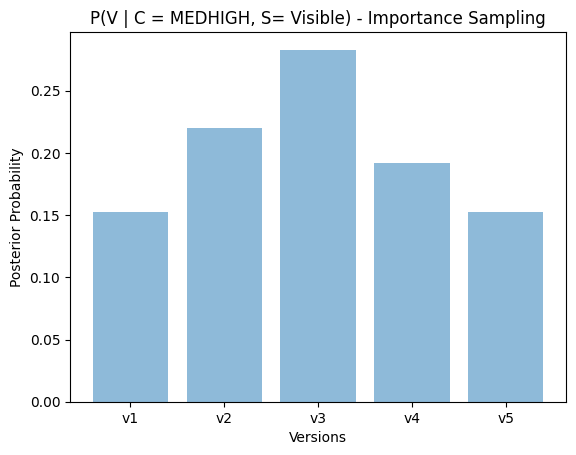

In [15]:
conditioned_model_1 = pyro.condition(model, data={'C':torch.tensor(2), 'S': torch.tensor(1)})

V_posterior = Importance(conditioned_model_1, num_samples=5000).run()
V_marginal = EmpiricalMarginal(V_posterior,"V")
V_samples = [V_marginal().item() for _ in range(5000)]
V_unique, V_counts = np.unique(V_samples, return_counts=True)

plt.bar(V_unique, V_counts/5000, align='center', alpha=0.5)
plt.xticks(V_unique, V_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Versions')
plt.title('P(V | C = MEDHIGH, S= Visible) - Importance Sampling')


Text(0.5, 1.0, 'P(V | do(C = MEDHIGH, S= Visible) - Importance Sampling')

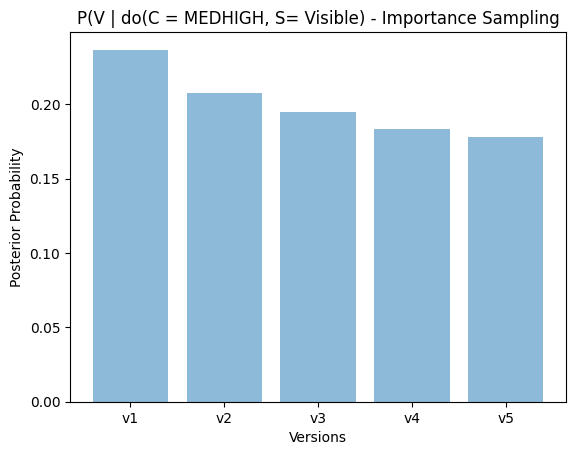

In [16]:
intervention_condition = pyro.do(model, data={'C':torch.tensor(2), 'S': torch.tensor(1)})

V_posterior = Importance(intervention_condition, num_samples=5000).run()
V_marginal = EmpiricalMarginal(V_posterior,"V")
V_samples = [V_marginal().item() for _ in range(5000)]
V_unique, V_counts = np.unique(V_samples, return_counts=True)

plt.bar(V_unique, V_counts/5000, align='center', alpha=0.5)
plt.xticks(V_unique, V_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Versions')
plt.title('P(V | do(C = MEDHIGH, S= Visible) - Importance Sampling')

Query 2: To find the probability of tag names given evidence about click rate.

Evidence: Click through is HIGH

Text(0.5, 1.0, 'P(T | C = HIGH) - Importance Sampling')

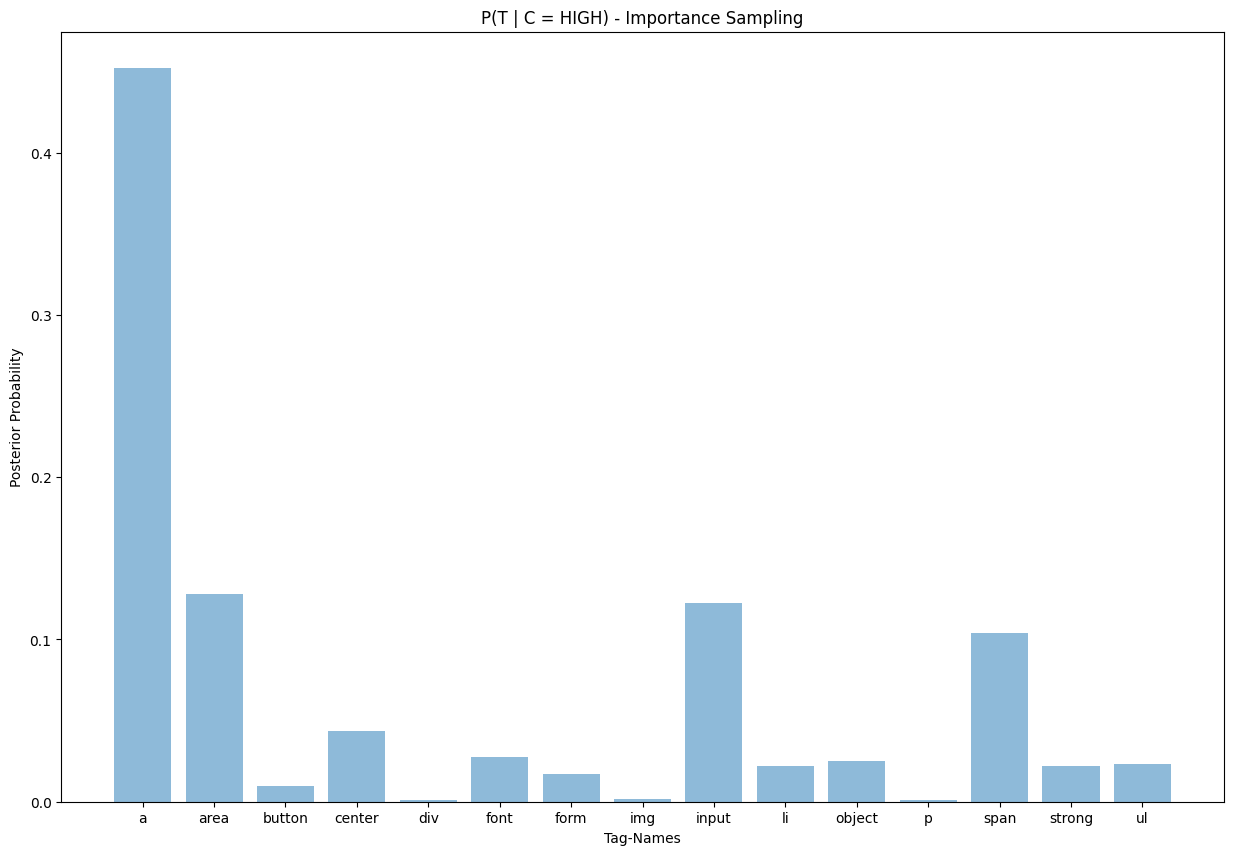

In [17]:
conditioned_model_2 = pyro.condition(model, data={'C':torch.tensor(0)})

T_posterior = Importance(conditioned_model_2, num_samples=5000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(5000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)
plt.figure(figsize=(15,10))
plt.bar(T_unique, T_counts/5000, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Tag-Names')
plt.title('P(T | C = HIGH) - Importance Sampling')

An interesting observation is that, from data, we see that the probability of the area tag in occuring is very low in 0.001 range. But given the evidence that the click rate is HIGH we see that the probability of the area tag goes up 10 fold.

Text(0.5, 1.0, 'P(C | do(Visible=True)) - Importance Sampling')

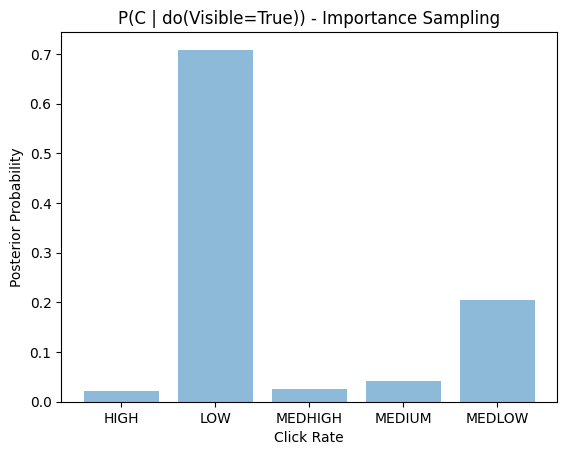

In [21]:
intervention_model_visible = pyro.do(model, data= {"S": torch.tensor(1)})
intervention_model_visible_no = pyro.condition(model, data= {"S": torch.tensor(0)})


C_posterior = Importance(intervention_model_visible, num_samples=5000).run()
C_marginal = EmpiricalMarginal(C_posterior,"C")
C_samples = [C_marginal().item() for _ in range(5000)]
C_unique, C_counts = np.unique(C_samples, return_counts=True)
plt.bar(C_unique, C_counts/5000, align='center', alpha=0.5)
plt.xticks(C_unique, C_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Click Rate')
plt.title('P(C | do(Visible=True)) - Importance Sampling')

##Causal Effect Query
Does Setting visibility to TRUE for all elements make any effect ?

In [22]:
def causal_effect(val):
  c_samples_visible = [
    1 if intervention_model_visible()['C'] == val else 0
    for _ in range(5000)
  ]
  c_samples_not_visible = [
      1 if intervention_model_visible_no()['C'] == val else 0
      for _ in range(5000)
  ]

  causal_effect = np.mean(c_samples_visible) - np.mean(c_samples_not_visible)
  return causal_effect

In [23]:
for lvl in C_alias:
  diff = causal_effect(C_alias.index(lvl))
  print(f"E(Click = {lvl} | do(Visible = True) - E(Click = {lvl} | do(Visible = False))) is {diff}")

E(Click = HIGH | do(Visible = True) - E(Click = HIGH | do(Visible = False))) is -0.011799999999999998
E(Click = LOW | do(Visible = True) - E(Click = LOW | do(Visible = False))) is -0.12919999999999998
E(Click = MEDHIGH | do(Visible = True) - E(Click = MEDHIGH | do(Visible = False))) is -0.012200000000000003
E(Click = MEDIUM | do(Visible = True) - E(Click = MEDIUM | do(Visible = False))) is -0.006399999999999996
E(Click = MEDLOW | do(Visible = True) - E(Click = MEDLOW | do(Visible = False))) is 0.1582


The likelihood of MED-LOW is enhanced and the probability of LOW is drastically decreased when all tags are made visible, as can be seen. By making all tags accessible, there is a 15% probability that the click rates will rise from the 0–10 range to the 10–100 range.

##Conclusion

Through the above use case of Click through rate we can observe causality w.r.t.
Visibility varied through HIGH, LOW and MEDIUM. and how these in affect impact the Click through rate.

##References

1. [Introduction to Causal Inference](https://www.bradyneal.com/causal-inference-course)
2.[Hernán MA, Robins JM (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.](https://www.hsph.harvard.edu/miguel-hernan/wp-content/uploads/sites/1268/2023/04/hernanrobins_WhatIf_31mar23.pdf)
3. [Series of Medium articles on Causal Inference and Its Fundamentals ](https://medium.com/data-science-at-microsoft/causal-inference-part-1-of-3-understanding-the-fundamentals-816f4723e54a)

4. [Causal Inference with Python](https://towardsdatascience.com/causal-inference-962ae97cefda)

License
All code in this notebook is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license. https://creativecommons.org/licenses/by/3.0/us/

These licenses let people distribute, remix, tweak, and build upon the work, even commercially, as long as they give credit for the original creation.

Copyright 2023 AI Skunks https://github.com/aiskunks

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

